In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, accuracy_score,f1_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from nltk.tokenize import RegexpTokenizer
from sklearn.pipeline import Pipeline
from nltk.corpus import names
from collections import defaultdict
import os,re
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from keras.preprocessing.text import Tokenizer
from nltk import word_tokenize
from nltk import pos_tag
from nltk import pos_tag_sents
from wordcloud import WordCloud
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Using TensorFlow backend.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
newsgroups = fetch_20newsgroups(subset='train') 
data = pd.Series(newsgroups.data)
df = pd.DataFrame(data)
df.columns = ['text'] + df.columns.tolist()[1:]
df['target'] = pd.Series(newsgroups.target)
df['target_names'] = pd.Series(newsgroups.target_names)
df

,text,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,alt.atheism
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.graphics
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.os.ms-windows.misc
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.sys.ibm.pc.hardware
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,comp.sys.mac.hardware
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,NaN
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,NaN
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,NaN
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,NaN


In [3]:
df1 = pd.read_json ("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")
df1.columns = ['text','target','target_names']
df1

,text,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [4]:
print('target labels the same: ',(df['target'] == df1['target']).all())
print('text the same: ',(df['text'] == df1['text']).all())
print('target names the same: ',(df['target_names'] == df1['target_names']).all())

target labels the same:  True
text the same:  True
target names the same:  False


In [5]:
target_name_dict = df1[['target','target_names']].drop_duplicates().set_index('target_names')['target'].sort_values().to_dict()

%store target_name_dict
target_name_dict

Stored 'target_name_dict' (dict)


{'alt.atheism': 0,
 'comp.graphics': 1,
 'comp.os.ms-windows.misc': 2,
 'comp.sys.ibm.pc.hardware': 3,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 5,
 'misc.forsale': 6,
 'rec.autos': 7,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 9,
 'rec.sport.hockey': 10,
 'sci.crypt': 11,
 'sci.electronics': 12,
 'sci.med': 13,
 'sci.space': 14,
 'soc.religion.christian': 15,
 'talk.politics.guns': 16,
 'talk.politics.mideast': 17,
 'talk.politics.misc': 18,
 'talk.religion.misc': 19}

In [6]:
newsgroups = fetch_20newsgroups(subset='all', remove=('quotes'))
data = pd.Series(newsgroups.data)
df = pd.DataFrame(data)
df.columns = ['text'] + df.columns.tolist()[1:]
df['target'] = pd.Series(newsgroups.target)
print(df.text[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [7]:
print(df.target[2216])

11


In [8]:
# make target name column

for k,v in target_name_dict.items():
    df.loc[df['target'] == v, 'target_name']=k

In [9]:
print('shape of dataframe: ', df.shape)
print('number of target variables: ',df.target.nunique())
print('null target variables: ', df.target.isna().any())
print('null text: ',df.text.isna().any())
print('null target names ',df.target_name.isna().any())

shape of dataframe:  (18846, 3)
number of target variables:  20
null target variables:  False
null text:  False
null target names  False


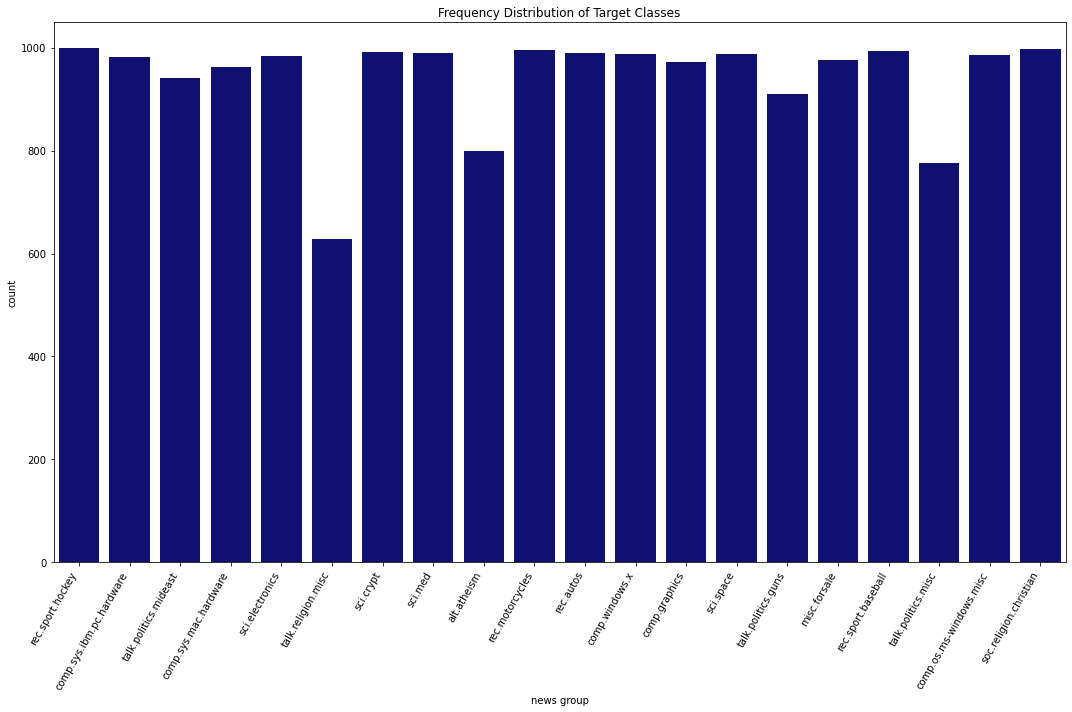

In [10]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='target_name', data=df,color='navy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.title('Frequency Distribution of Target Classes')
plt.xlabel('news group')
plt.tight_layout()
plt.show()

In [11]:
df

,text,target,target_name
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware
...,...,...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...,12,sci.electronics
18843,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [12]:
#fix apostrophes so all stop words are removed
 
lexicon = (
    (re.compile(r"\bdon't\b"), "do not"),
    (re.compile(r"\bit's\b"), "it is"),
    (re.compile(r"\bi'm\b"), "i am"),
    (re.compile(r"\bi've\b"), "i have"),
    (re.compile(r"\bcan't\b"), "cannot"),
    (re.compile(r"\bdoesn't\b"), "does not"),
    (re.compile(r"\bthat's\b"), "that is"),
    (re.compile(r"\bdidn't\b"), "did not"),
    (re.compile(r"\bi'd\b"), "i would"),
    (re.compile(r"\byou're\b"), "you are"),
    (re.compile(r"\bisn't\b"), "is not"),
    (re.compile(r"\bi'll\b"), "i will"),
    (re.compile(r"\bthere's\b"), "there is"),
    (re.compile(r"\bwon't\b"), "will not"),
    (re.compile(r"\bwoudn't\b"), "would not"),
    (re.compile(r"\bhe's\b"), "he is"),
    (re.compile(r"\bthey're\b"), "they are"),
    (re.compile(r"\bwe're\b"), "we are"),
    (re.compile(r"\blet's\b"), "let us"),
    (re.compile(r"\bhaven't\b"), "have not"),
    (re.compile(r"\bwhat's\b"), "what is"),
    (re.compile(r"\baren't\b"), "are not"),
    (re.compile(r"\bwasn't\b"), "was not"),
    (re.compile(r"\bwouldn't\b"), "would not"),
)

def fix_apostrophes(text):
    text = text.lower()
    
    for pattern, replacement in lexicon:
        text = pattern.sub(replacement, text)

    return text

df.text = df.text.apply(lambda row: fix_apostrophes(row))

In [13]:
#remove emails
df['text'] = df['text'].apply(lambda row: re.sub(r"\S*@\S*\s?","",row))

#remove single quote marks
df['text'] = df['text'].apply(lambda row: re.sub(r"\'","",row))

#make all text lower case
df['text'] = df['text'].str.lower()

#remove numerics
df['text'] = df['text'].apply(lambda row: re.sub(r"\d+","",row))

#remove words with fewer than 3 characters
df['text'] = df['text'].apply(lambda row: re.sub(r'\b\w{1,2}\b', '',row))

#remove extra spaces
df['text'] = df['text'].apply(lambda row: re.sub(r"\s+"," ",row))

df

,text,target,target_name
0,from: mamatha devineni ratnam subject: pens fa...,10,rec.sport.hockey
1,from: (matthew lawson) subject: which high-per...,3,comp.sys.ibm.pc.hardware
2,from: (hilmi eren) subject: : armenia says cou...,17,talk.politics.mideast
3,"from: (guy dawson) subject: : ide scsi, dma an...",3,comp.sys.ibm.pc.hardware
4,from: alexander samuel mcdiarmid subject: driv...,4,comp.sys.mac.hardware
...,...,...,...
18841,from: (jim zisfein) subject: : migraines and s...,13,sci.med
18842,from: (richard..dell) subject: : question abou...,12,sci.electronics
18843,from: (will estes) subject: mounting cpu coole...,3,comp.sys.ibm.pc.hardware
18844,from: (steven collins) subject: : sphere from ...,1,comp.graphics


In [14]:
df.isna().any()

text           False
target         False
target_name    False
dtype: bool

In [15]:
#define stop words
stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(['one','posting','nntp','host','subject','problem','program','line','think','say','god','people','system','organization','drive','know'])

In [16]:
#instatiate regexptokenizer and remove symbols
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

#tokenize test
df['tokenized_text'] = df.apply(lambda row: tokenizer.tokenize(row['text']),axis=1)

#remove stop words
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item not in stopwords])

#instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

#lemmatize text
df['lemmatized_list'] = df['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df['lemmatized'] = df['lemmatized_list'].apply(lambda x: " ".join(x) )

df.sample(5)

,text,target,target_name,tokenized_text,lemmatized_list,lemmatized
9601,from: (chris lilley) subject: : help: need bit...,1,comp.graphics,"[chris, lilley, help, need, bits, viewer, keyw...","[chris, lilley, help, need, bit, viewer, keywo...",chris lilley help need bit viewer keywords bit...
11981,"from: (steve brinich) subject: : fear, uncerta...",11,sci.crypt,"[steve, brinich, fear, uncertainty, doubt, exp...","[steve, brinich, fear, uncertainty, doubt, exp...",steve brinich fear uncertainty doubt express a...
17862,from: (joerg wunsch) subject: about the variou...,1,comp.graphics,"[joerg, wunsch, various, dxf, format, question...","[joerg, wunsch, various, dxf, format, question...",joerg wunsch various dxf format question saxne...
15059,from: (amanda walker) subject: : screw the peo...,11,sci.crypt,"[amanda, walker, screw, crypto, hard, core, ha...","[amanda, walker, screw, crypto, hard, core, ha...",amanda walker screw crypto hard core hacker sp...
11159,from: (jon livesey) subject: : objective moral...,0,alt.atheism,"[jon, livesey, objective, morality, political,...","[jon, livesey, objective, morality, political,...",jon livesey objective morality political athei...


In [17]:
print(df.tokenized_text[0])

['mamatha', 'devineni', 'ratnam', 'pens', 'fans', 'reactions', 'post', 'office', 'carnegie', 'mellon', 'pittsburgh', 'lines', 'andrew', 'cmu', 'edu', 'sure', 'bashers', 'pens', 'fans', 'pretty', 'confused', 'lack', 'kind', 'posts', 'recent', 'pens', 'massacre', 'devils', 'actually', 'bit', 'puzzled', 'bit', 'relieved', 'however', 'going', 'put', 'end', 'non', 'pittsburghers', 'relief', 'bit', 'praise', 'pens', 'man', 'killing', 'devils', 'worse', 'thought', 'jagr', 'showed', 'much', 'better', 'regular', 'season', 'stats', 'also', 'lot', 'fun', 'watch', 'playoffs', 'bowman', 'let', 'jagr', 'lot', 'fun', 'next', 'couple', 'games', 'since', 'pens', 'going', 'beat', 'pulp', 'jersey', 'anyway', 'disappointed', 'see', 'islanders', 'lose', 'final', 'regular', 'season', 'game', 'pens', 'rule']


In [18]:
print(df.lemmatized[0])

mamatha devineni ratnam pen fan reaction post office carnegie mellon pittsburgh line andrew cmu edu sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved however going put end non pittsburghers relief bit praise pen man killing devil worse thought jagr showed much better regular season stats also lot fun watch playoff bowman let jagr lot fun next couple game since pen going beat pulp jersey anyway disappointed see islander lose final regular season game pen rule


In [19]:
df.tokenized_text.isna().any()

False

In [20]:
df.rename(columns={'lemmatized':'preprocessed_text'},inplace=True)

df

,text,target,target_name,tokenized_text,lemmatized_list,preprocessed_text
0,from: mamatha devineni ratnam subject: pens fa...,10,rec.sport.hockey,"[mamatha, devineni, ratnam, pens, fans, reacti...","[mamatha, devineni, ratnam, pen, fan, reaction...",mamatha devineni ratnam pen fan reaction post ...
1,from: (matthew lawson) subject: which high-per...,3,comp.sys.ibm.pc.hardware,"[matthew, lawson, high, performance, vlb, vide...","[matthew, lawson, high, performance, vlb, vide...",matthew lawson high performance vlb video card...
2,from: (hilmi eren) subject: : armenia says cou...,17,talk.politics.mideast,"[hilmi, eren, armenia, says, could, shoot, tur...","[hilmi, eren, armenia, say, could, shoot, turk...",hilmi eren armenia say could shoot turkish pla...
3,"from: (guy dawson) subject: : ide scsi, dma an...",3,comp.sys.ibm.pc.hardware,"[guy, dawson, ide, scsi, dma, detach, originat...","[guy, dawson, ide, scsi, dma, detach, originat...",guy dawson ide scsi dma detach originator ibm ...
4,from: alexander samuel mcdiarmid subject: driv...,4,comp.sys.mac.hardware,"[alexander, samuel, mcdiarmid, driver, sophomo...","[alexander, samuel, mcdiarmid, driver, sophomo...",alexander samuel mcdiarmid driver sophomore me...
...,...,...,...,...,...,...
18841,from: (jim zisfein) subject: : migraines and s...,13,sci.med,"[jim, zisfein, migraines, scans, distribution,...","[jim, zisfein, migraine, scan, distribution, w...",jim zisfein migraine scan distribution world i...
18842,from: (richard..dell) subject: : question abou...,12,sci.electronics,"[richard, dell, question, vac, outlet, wiring,...","[richard, dell, question, vac, outlet, wiring,...",richard dell question vac outlet wiring distri...
18843,from: (will estes) subject: mounting cpu coole...,3,comp.sys.ibm.pc.hardware,"[estes, mounting, cpu, cooler, vertical, case,...","[estes, mounting, cpu, cooler, vertical, case,...",estes mounting cpu cooler vertical case mail g...
18844,from: (steven collins) subject: : sphere from ...,1,comp.graphics,"[steven, collins, sphere, points, central, res...","[steven, collins, sphere, point, central, rese...",steven collins sphere point central research l...


In [21]:
wpt = nltk.WordPunctTokenizer()

In [22]:
pos_tag_list = []
for number in range(0,len(df['preprocessed_text'])):
    new_text = []
    text = wpt.tokenize(df['preprocessed_text'][number])
# #     print(text)
    text_tagged = nltk.pos_tag(text)
#     print(text_tagged)
    for word in text_tagged:
        new_text.append(word[0] + "_" + word[1])
        doc = ' '.join(new_text)
    doc_list = wpt.tokenize(doc)
    pos_tag_list.append(doc_list)
        

In [23]:
df.loc[:,'pos_tags'] = pos_tag_list
df['pos_tags'] = df['pos_tags'].apply(lambda x: " ".join(x))
df

,text,target,target_name,tokenized_text,lemmatized_list,preprocessed_text,pos_tags
0,from: mamatha devineni ratnam subject: pens fa...,10,rec.sport.hockey,"[mamatha, devineni, ratnam, pens, fans, reacti...","[mamatha, devineni, ratnam, pen, fan, reaction...",mamatha devineni ratnam pen fan reaction post ...,mamatha_NN devineni_NN ratnam_NN pen_VB fan_NN...
1,from: (matthew lawson) subject: which high-per...,3,comp.sys.ibm.pc.hardware,"[matthew, lawson, high, performance, vlb, vide...","[matthew, lawson, high, performance, vlb, vide...",matthew lawson high performance vlb video card...,matthew_NN lawson_NN high_JJ performance_NN vl...
2,from: (hilmi eren) subject: : armenia says cou...,17,talk.politics.mideast,"[hilmi, eren, armenia, says, could, shoot, tur...","[hilmi, eren, armenia, say, could, shoot, turk...",hilmi eren armenia say could shoot turkish pla...,hilmi_NN eren_NNS armenia_VBP say_VB could_MD ...
3,"from: (guy dawson) subject: : ide scsi, dma an...",3,comp.sys.ibm.pc.hardware,"[guy, dawson, ide, scsi, dma, detach, originat...","[guy, dawson, ide, scsi, dma, detach, originat...",guy dawson ide scsi dma detach originator ibm ...,guy_NN dawson_NN ide_NN scsi_NN dma_NN detach_...
4,from: alexander samuel mcdiarmid subject: driv...,4,comp.sys.mac.hardware,"[alexander, samuel, mcdiarmid, driver, sophomo...","[alexander, samuel, mcdiarmid, driver, sophomo...",alexander samuel mcdiarmid driver sophomore me...,alexander_NN samuel_NN mcdiarmid_NN driver_NN ...
...,...,...,...,...,...,...,...
18841,from: (jim zisfein) subject: : migraines and s...,13,sci.med,"[jim, zisfein, migraines, scans, distribution,...","[jim, zisfein, migraine, scan, distribution, w...",jim zisfein migraine scan distribution world i...,jim_NN zisfein_CD migraine_JJ scan_JJ distribu...
18842,from: (richard..dell) subject: : question abou...,12,sci.electronics,"[richard, dell, question, vac, outlet, wiring,...","[richard, dell, question, vac, outlet, wiring,...",richard dell question vac outlet wiring distri...,richard_NN dell_NN question_NN vac_FW outlet_N...
18843,from: (will estes) subject: mounting cpu coole...,3,comp.sys.ibm.pc.hardware,"[estes, mounting, cpu, cooler, vertical, case,...","[estes, mounting, cpu, cooler, vertical, case,...",estes mounting cpu cooler vertical case mail g...,estes_NNS mounting_VBG cpu_NN cooler_NN vertic...
18844,from: (steven collins) subject: : sphere from ...,1,comp.graphics,"[steven, collins, sphere, points, central, res...","[steven, collins, sphere, point, central, rese...",steven collins sphere point central research l...,steven_RB collins_NNS sphere_RB point_JJ centr...


In [24]:
df['lemmatized_and_pos'] = df.preprocessed_text + ' ' + df.pos_tags



In [25]:
df['lemmatized_and_pos'][0]

'mamatha devineni ratnam pen fan reaction post office carnegie mellon pittsburgh line andrew cmu edu sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved however going put end non pittsburghers relief bit praise pen man killing devil worse thought jagr showed much better regular season stats also lot fun watch playoff bowman let jagr lot fun next couple game since pen going beat pulp jersey anyway disappointed see islander lose final regular season game pen rule mamatha_NN devineni_NN ratnam_NN pen_VB fan_NN reaction_NN post_NN office_NN carnegie_NN mellon_NN pittsburgh_NN line_NN andrew_VBD cmu_JJ edu_JJ sure_JJ bashers_NNS pen_VBP fan_NN pretty_RB confused_JJ lack_NN kind_NN post_NN recent_JJ pen_JJ massacre_NN devil_NN actually_RB bit_RB puzzled_JJ bit_NN relieved_VBD however_RB going_VBG put_VBN end_VB non_NN pittsburghers_NNS relief_VBP bit_RB praise_JJ pen_JJ man_NN killing_VBG devil_JJ worse_JJR thought_NN jagr_NN showed

In [26]:
#replace empty strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [27]:
#drop nan cells
df.dropna(inplace=True)

In [28]:
df

,text,target,target_name,tokenized_text,lemmatized_list,preprocessed_text,pos_tags,lemmatized_and_pos
0,from: mamatha devineni ratnam subject: pens fa...,10,rec.sport.hockey,"[mamatha, devineni, ratnam, pens, fans, reacti...","[mamatha, devineni, ratnam, pen, fan, reaction...",mamatha devineni ratnam pen fan reaction post ...,mamatha_NN devineni_NN ratnam_NN pen_VB fan_NN...,mamatha devineni ratnam pen fan reaction post ...
1,from: (matthew lawson) subject: which high-per...,3,comp.sys.ibm.pc.hardware,"[matthew, lawson, high, performance, vlb, vide...","[matthew, lawson, high, performance, vlb, vide...",matthew lawson high performance vlb video card...,matthew_NN lawson_NN high_JJ performance_NN vl...,matthew lawson high performance vlb video card...
2,from: (hilmi eren) subject: : armenia says cou...,17,talk.politics.mideast,"[hilmi, eren, armenia, says, could, shoot, tur...","[hilmi, eren, armenia, say, could, shoot, turk...",hilmi eren armenia say could shoot turkish pla...,hilmi_NN eren_NNS armenia_VBP say_VB could_MD ...,hilmi eren armenia say could shoot turkish pla...
3,"from: (guy dawson) subject: : ide scsi, dma an...",3,comp.sys.ibm.pc.hardware,"[guy, dawson, ide, scsi, dma, detach, originat...","[guy, dawson, ide, scsi, dma, detach, originat...",guy dawson ide scsi dma detach originator ibm ...,guy_NN dawson_NN ide_NN scsi_NN dma_NN detach_...,guy dawson ide scsi dma detach originator ibm ...
4,from: alexander samuel mcdiarmid subject: driv...,4,comp.sys.mac.hardware,"[alexander, samuel, mcdiarmid, driver, sophomo...","[alexander, samuel, mcdiarmid, driver, sophomo...",alexander samuel mcdiarmid driver sophomore me...,alexander_NN samuel_NN mcdiarmid_NN driver_NN ...,alexander samuel mcdiarmid driver sophomore me...
...,...,...,...,...,...,...,...,...
18841,from: (jim zisfein) subject: : migraines and s...,13,sci.med,"[jim, zisfein, migraines, scans, distribution,...","[jim, zisfein, migraine, scan, distribution, w...",jim zisfein migraine scan distribution world i...,jim_NN zisfein_CD migraine_JJ scan_JJ distribu...,jim zisfein migraine scan distribution world i...
18842,from: (richard..dell) subject: : question abou...,12,sci.electronics,"[richard, dell, question, vac, outlet, wiring,...","[richard, dell, question, vac, outlet, wiring,...",richard dell question vac outlet wiring distri...,richard_NN dell_NN question_NN vac_FW outlet_N...,richard dell question vac outlet wiring distri...
18843,from: (will estes) subject: mounting cpu coole...,3,comp.sys.ibm.pc.hardware,"[estes, mounting, cpu, cooler, vertical, case,...","[estes, mounting, cpu, cooler, vertical, case,...",estes mounting cpu cooler vertical case mail g...,estes_NNS mounting_VBG cpu_NN cooler_NN vertic...,estes mounting cpu cooler vertical case mail g...
18844,from: (steven collins) subject: : sphere from ...,1,comp.graphics,"[steven, collins, sphere, points, central, res...","[steven, collins, sphere, point, central, rese...",steven collins sphere point central research l...,steven_RB collins_NNS sphere_RB point_JJ centr...,steven collins sphere point central research l...


In [29]:
#train test validation split

X,y = df.preprocessed_text,df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [30]:
train_df = X_train.to_frame().merge(y_train.to_frame(),left_index=True,right_index=True)
val_df = X_val.to_frame().merge(y_val.to_frame(),left_index=True,right_index=True)
test_df = X_test.to_frame().merge(y_test.to_frame(),left_index=True,right_index=True)

In [31]:
train_df.to_csv(r'Data/train.csv', index = False)
val_df.to_csv(r'Data/val.csv', index = False)
test_df.to_csv(r'Data/test.csv', index = False)

In [32]:
X,y = df.lemmatized_and_pos,df.target

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(X_train_pos, y_train_pos, test_size=0.25, random_state=42)

In [33]:
train_df_pos = X_train_pos.to_frame().merge(y_train_pos.to_frame(),left_index=True,right_index=True)
val_df_pos = X_val_pos.to_frame().merge(y_val_pos.to_frame(),left_index=True,right_index=True)
test_df_pos = X_test_pos.to_frame().merge(y_test_pos.to_frame(),left_index=True,right_index=True)

train_df_pos.to_csv(r'Data/train_pos.csv', index = False)
val_df_pos.to_csv(r'Data/val_pos.csv', index = False)
test_df_pos.to_csv(r'Data/test_pos.csv', index = False)

In [34]:
tfidf = TfidfVectorizer(min_df = 10)
tfidf_train_sparse = tfidf.fit_transform(X_train)
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), 
                        columns=tfidf.get_feature_names())

# pd.set_option('display.max_columns', None)

tfidf_train_df.head()

,aaa,aaron,ab,abandon,abandoned,abc,abiding,ability,able,abo,...,zeus,zinc,zion,zionism,zionist,zip,zone,zoology,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
tfidf_val_sparse = tfidf.transform(X_val)
tfidf_val_df = pd.DataFrame(tfidf_val_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_val_df.head()




,aaa,aaron,ab,abandon,abandoned,abc,abiding,ability,able,abo,...,zeus,zinc,zion,zionism,zionist,zip,zone,zoology,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
tfidf_test_sparse = tfidf.transform(X_test)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_test_df.head()

,aaa,aaron,ab,abandon,abandoned,abc,abiding,ability,able,abo,...,zeus,zinc,zion,zionism,zionist,zip,zone,zoology,zoom,zurich
0,0.133861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.395447,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010346,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [37]:
tfidf_pos = TfidfVectorizer(min_df = 10)
tfidf_train_sparse_pos = tfidf_pos.fit_transform(X_train_pos)
tfidf_train_df_pos = pd.DataFrame(tfidf_train_sparse_pos.toarray(), 
                        columns=tfidf_pos.get_feature_names())

tfidf_train_df_pos.head()

,aaa,aaa_nn,aaron,aaron_nn,ab,ab_nn,abandon,abandoned,abandoned_vbd,abandoned_vbn,...,zip,zip_nn,zone,zone_cd,zone_nn,zoology,zoology_nn,zoom,zoom_nn,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:

tfidf_val_sparse_pos = tfidf_pos.fit_transform(X_val_pos)
tfidf_val_df_pos = pd.DataFrame(tfidf_val_sparse_pos.toarray(), 
                        columns=tfidf_pos.get_feature_names())

tfidf_val_df_pos.head()

,aaron,aaron_nn,abc,abiding,abiding_vbg,ability,ability_nn,able,able_jj,abortion,...,zero_cd,zeus,zeus_nn,zip,zip_nn,zone,zone_cd,zone_nn,zoom,zoom_nn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.134584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
tfidf_test_sparse_pos = tfidf_pos.fit_transform(X_test_pos)
tfidf_test_df_pos = pd.DataFrame(tfidf_test_sparse_pos.toarray(), 
                        columns=tfidf_pos.get_feature_names())

tfidf_test_df_pos.head()

,aaron,aaron_nn,abc,abc_nn,abiding,abiding_vbg,ability,ability_nn,able,able_jj,...,zeus_nn,zionist,zionist_nn,zip,zip_nn,zone,zone_cd,zone_nn,zoology,zoology_nn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.329436,0.334315,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007883,0.007883,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


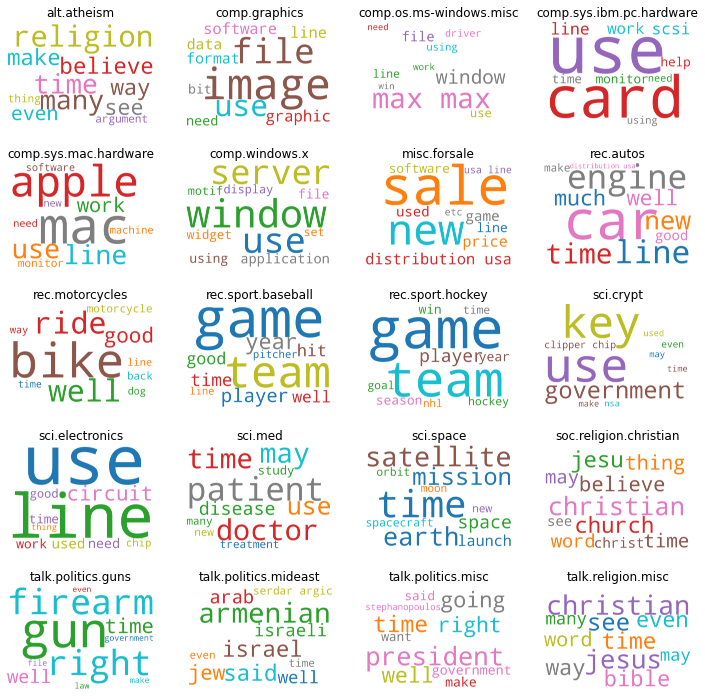

In [40]:
cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0)

topics=[]
for key, value in target_name_dict.items():
    temp = [key,value]
    topics.append(temp)

fig, axes = plt.subplots(5, 4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic = topics[i][1]
    cloud.generate(str(df.loc[df.target == topic]['preprocessed_text'].values))
    plt.gca().imshow(cloud)
    plt.gca().set_title(topics[i][0])
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [41]:
from sklearn.decomposition import TruncatedSVD

skl_decomp_obj = TruncatedSVD(n_components=3500, n_iter=100, random_state=42)

tfidf_lsa_data = skl_decomp_obj.fit_transform(tfidf_train_df)

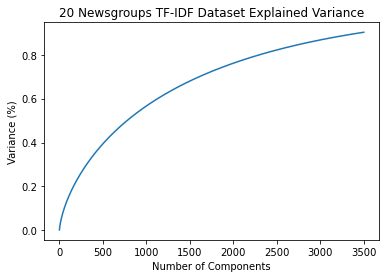

<Figure size 432x288 with 0 Axes>

In [42]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(skl_decomp_obj.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('20 Newsgroups TF-IDF Dataset Explained Variance')
plt.show()
plt.savefig('decomp.png')

In [43]:
skl_decomp_obj_pos = TruncatedSVD(n_components=3500, n_iter=100, random_state=42)

tfidf_lsa_data_pos = skl_decomp_obj_pos.fit_transform(tfidf_train_df_pos)

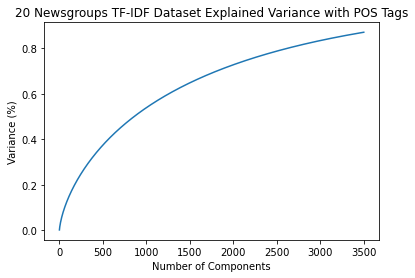

<Figure size 432x288 with 0 Axes>

In [44]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(skl_decomp_obj_pos.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('20 Newsgroups TF-IDF Dataset Explained Variance with POS Tags')
plt.show()
plt.savefig('decomp_pos.png')